In [10]:
import pandas as pd

# Load the dataset
df = pd.read_csv('ecommerce_customer_data_large.csv')
df.head()  # Display the first few rows


,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,44605,2023-05-03 21:30:02,Home,177,1,2427,PayPal,31,1.0,John Rivera,31,Female,0
1,44605,2021-05-16 13:57:44,Electronics,174,3,2448,PayPal,31,1.0,John Rivera,31,Female,0
2,44605,2020-07-13 06:16:57,Books,413,1,2345,Credit Card,31,1.0,John Rivera,31,Female,0
3,44605,2023-01-17 13:14:36,Electronics,396,3,937,Cash,31,0.0,John Rivera,31,Female,0
4,44605,2021-05-01 11:29:27,Books,259,4,2598,PayPal,31,1.0,John Rivera,31,Female,0


In [12]:
# Check data types and missing values
df.info()

# Summary statistics
df.describe()

# Check for null values
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Customer ID            250000 non-null  int64  
 1   Purchase Date          250000 non-null  object 
 2   Product Category       250000 non-null  object 
 3   Product Price          250000 non-null  int64  
 4   Quantity               250000 non-null  int64  
 5   Total Purchase Amount  250000 non-null  int64  
 6   Payment Method         250000 non-null  object 
 7   Customer Age           250000 non-null  int64  
 8   Returns                202618 non-null  float64
 9   Customer Name          250000 non-null  object 
 10  Age                    250000 non-null  int64  
 11  Gender                 250000 non-null  object 
 12  Churn                  250000 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 24.8+ MB


Customer ID                  0
Purchase Date                0
Product Category             0
Product Price                0
Quantity                     0
Total Purchase Amount        0
Payment Method               0
Customer Age                 0
Returns                  47382
Customer Name                0
Age                          0
Gender                       0
Churn                        0
dtype: int64

In [14]:
# Fill missing Returns with 0 (indicating no returns)
df.fillna({'Returns':0}, inplace=True)

# Verify the changes
print("Missing values in Returns after handling:", df['Returns'].isnull().sum())


Missing values in Returns after handling: 0


In [16]:
# Convert 'Purchase Date' to datetime
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'])

# Handle missing values (example: filling missing ages with the median)
df.fillna({'Customer Age': df['Customer Age'].median()}, inplace=True)


df.head()
df.to_csv('cleaned_cs_dataset.csv',index= False)
print("cleaned dataset have been saved successfully")

cleaned dataset have been saved successfully


In [18]:
import datetime

# Define a reference date (e.g., the most recent purchase)
today_date = datetime.datetime.now()

# Calculate Recency (difference in days from the last purchase)
df['Recency'] = (today_date - df['Purchase Date']).dt.days


In [20]:
# Calculate the frequency of purchases for each customer
frequency = df.groupby('Customer ID')['Purchase Date'].count().reset_index()
frequency.columns = ['Customer ID', 'Frequency']

# Merge this frequency data with your main dataframe
df = pd.merge(df, frequency, on='Customer ID', how='left')



In [22]:
# If 'Monetary' already exists, drop it
if 'Monetary' in df.columns:
    df.drop(columns=['Monetary'], inplace=True)

# Calculate the monetary value (total amount spent) by each customer
monetary = df.groupby('Customer ID')['Total Purchase Amount'].sum().reset_index()
monetary.columns = ['Customer ID', 'Monetary']

# Now, merge this monetary data with your main dataframe
df = pd.merge(df, monetary, on='Customer ID', how='left')


In [26]:
from sklearn.preprocessing import StandardScaler

# Select RFM columns
rfm = df[['Recency', 'Frequency', 'Monetary']]

# Scale the values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)
print(rfm)
print(rfm_scaled)


        Recency  Frequency  Monetary
0           561          5     10755
1          1278          5     10755
2          1585          5     10755
3           667          5     10755
4          1293          5     10755
...         ...        ...       ...
249995      660          1      3664
249996     1259          1      4374
249997      735          1      5296
249998     1236          1      2517
249999     1529          1      3634

[250000 rows x 3 columns]
[[-1.39079126 -0.44499648 -0.79108145]
 [ 0.4469702  -0.44499648 -0.79108145]
 [ 1.23384994 -0.44499648 -0.79108145]
 ...
 [-0.94480731 -2.23388392 -1.56543481]
 [ 0.3393189  -2.23388392 -1.95963301]
 [ 1.09031487 -2.23388392 -1.80118774]]


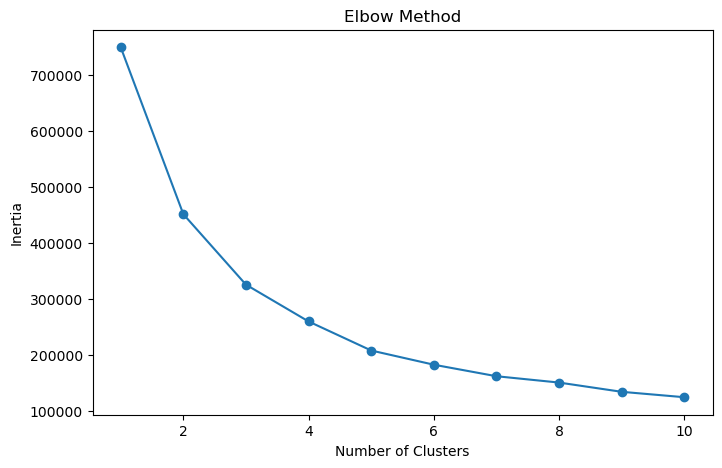

In [28]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Use the Elbow Method to find the optimal number of clusters
inertia = []
for k in range(1, 11):  # Try 1 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


In [32]:
# Fit K-Means with the chosen number of clusters (here 5)
optimal_k = 5  
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(rfm_scaled)

# Add the cluster labels to the dataframe
df['Cluster'] = kmeans.labels_


In [34]:
# Group by clusters and calculate the mean values for RFM metrics
cluster_summary = df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
print(cluster_summary)


             Recency  Frequency      Monetary
Cluster                                      
0        1077.017506   9.923488  28932.367548
1        1459.490520   6.983715  19380.002896
2         768.104274   3.996118  10070.401224
3        1440.924302   4.163884  10597.394275
4         757.208597   6.767764  18655.095243


C:\Users\HARATHI\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


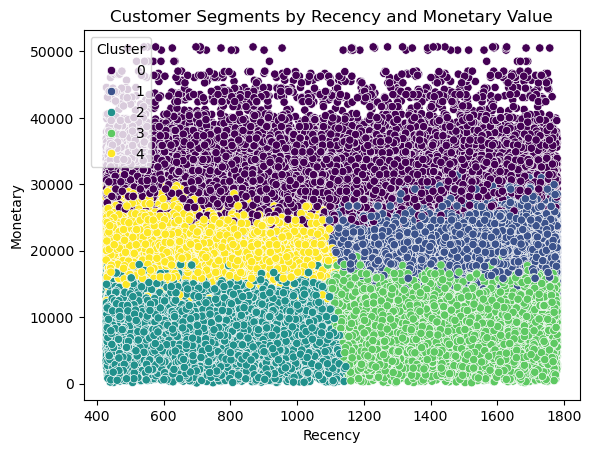

In [55]:
import seaborn as sns

# Visualize clusters with a scatter plot
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=df, palette='viridis')
plt.title('Customer Segments by Recency and Monetary Value')
plt.show()


In [48]:
# View the cluster profiles with additional columns
cluster_profiles = df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Customer Age': 'mean',
    'Gender': lambda x: x.value_counts().index[0]  # Most common gender
})
# Round the 'Customer Age' column to whole numbers for better readability
cluster_profiles['Customer Age'] = cluster_profiles['Customer Age'].round(0)
print(cluster_profiles)


             Recency  Frequency      Monetary  Customer Age Gender
Cluster                                                           
0        1073.826491   9.926251  28943.152071          45.0   Male
1         764.604314   3.998626  10079.142145          43.0   Male
2        1456.033375   6.984650  19382.878141          44.0   Male
3        1437.439654   4.164417  10598.327746          43.0   Male
4         753.801672   6.771663  18666.491993          44.0   Male


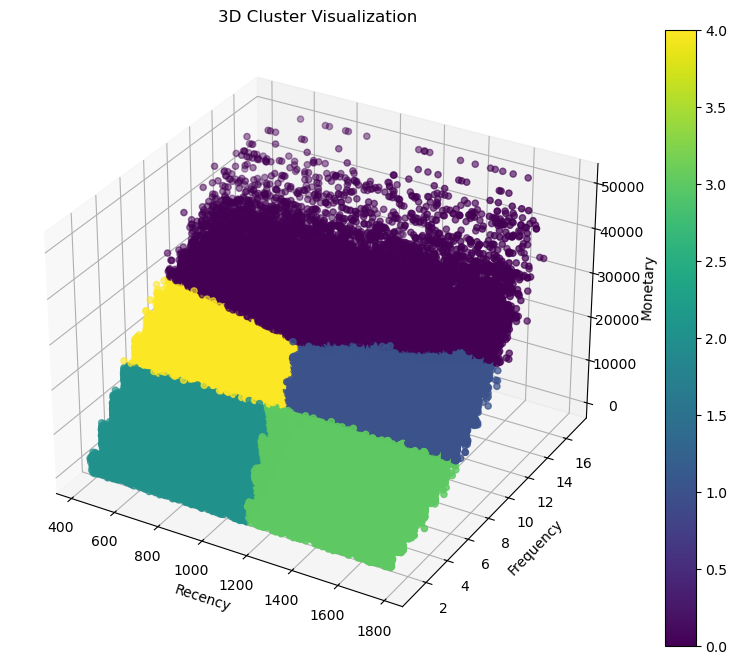

In [40]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df['Recency'], df['Frequency'], df['Monetary'], c=df['Cluster'], cmap='viridis')
plt.colorbar(sc)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('3D Cluster Visualization')
plt.show()


In [45]:
from sklearn.metrics import silhouette_score

score = silhouette_score(rfm_scaled, df['Cluster'])
print(f'Silhouette Score: {score}')


Silhouette Score: 0.3129369545033009


In [47]:
# Set optimal_k based on your analysis
#optimal_k = 5  # Example value
#from sklearn.cluster import KMeans

# Define and fit the model
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', n_init=10, random_state=42)
kmeans.fit(rfm_scaled)



KMeans(n_clusters=5, n_init=10, random_state=42)

In [49]:
import joblib

# Save the model
joblib.dump(kmeans, 'kmeans_model.pkl')

# To load the model later
kmeans_loaded = joblib.load('kmeans_model.pkl')


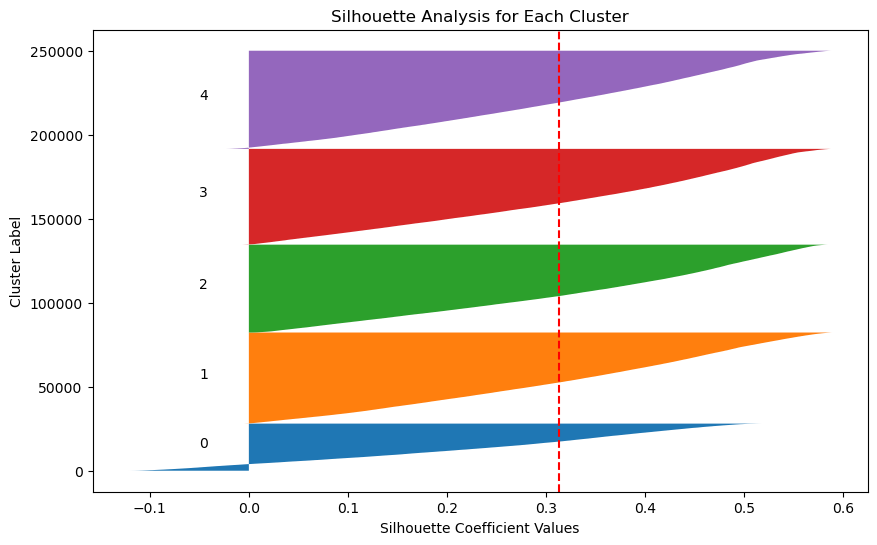

In [51]:
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

# Calculate silhouette scores for each data point
sample_silhouette_values = silhouette_samples(rfm_scaled, df['Cluster'])

# Plot silhouette scores
plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(optimal_k):
    # Aggregate silhouette scores for the cluster and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[df['Cluster'] == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for spacing between plots

plt.title('Silhouette Analysis for Each Cluster')
plt.xlabel('Silhouette Coefficient Values')
plt.ylabel('Cluster Label')
plt.axvline(x=score, color='red', linestyle='--')
plt.show()


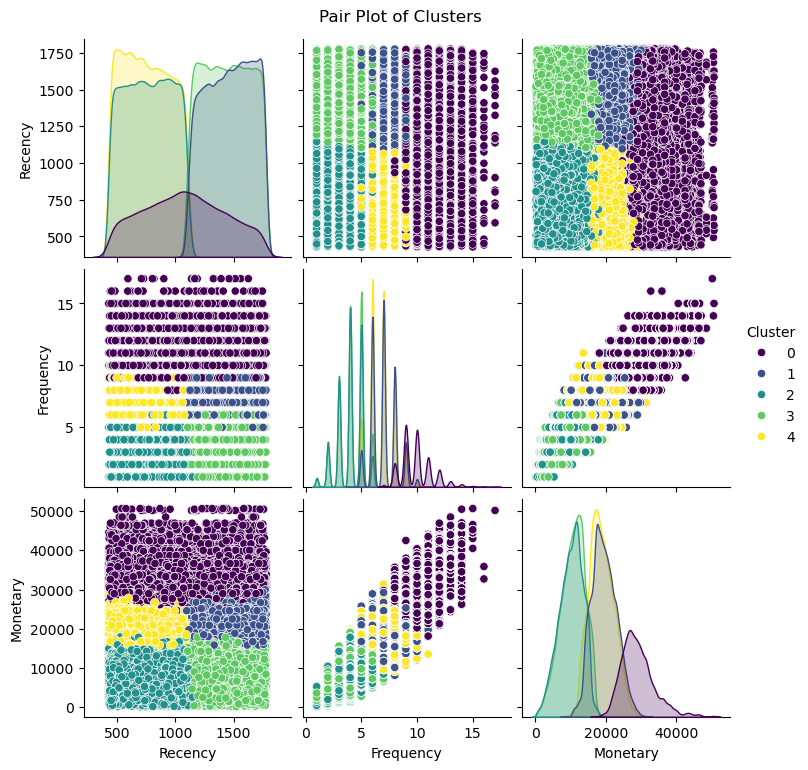

In [53]:
sns.pairplot(df, hue='Cluster', vars=['Recency', 'Frequency', 'Monetary'], palette='viridis')
plt.suptitle('Pair Plot of Clusters', y=1.02)
plt.show()
